In [252]:
import numpy as np

class MyRegressor:
    def __init__(self) -> None:
        self.W = []
        self.X = []

    def get_parameters(self):
        return self.W
    
    def predict(self,x):
        l = []
        for i in range(len(x)):
            c = self.W[0]
            for j in range(len(x[i])):
                c += float(self.W[j+1]) * x[i][j]
            l.append(c)
        return l

    def train(self, training_input_set, training_output_set):
        self.X = [[1 for _ in range(len(training_input_set))],[x[-1] for x in training_input_set.copy()]]
        XT = self.__transpose_matrix(self.X)
        P = self.__product(XT,self.X)
        P_Invers = self.__inversa(P)

        A = self.__product(P_Invers,XT)
        print(A.shape)
        Y = [el for el in training_output_set.copy()]
        print(len(Y))
        self.W = self.__product(Y,A)
        print(self.W)
        
    def __transpose_matrix(self, A):
        n, m = len(A), len(A[-1])
        XT = [[] for _ in range(m)]
        for i in range(n):
            for j in range(m):
                XT[j].append(A[i][j])
        return XT

    def __product(self,A,B):
        return np.matmul(A,B)
        nr_lines = len(A)
        nr_cols = len(B[-1])
        prod = []
        for i in range(nr_lines):
            prod.append([])
            for j in range(nr_cols):
                prod[i].append(sum([A[i][k] * B[k][j] for k in range(len(A[i]))]))

        return prod          

    def __elimLinCol(self, A, i:int, j:int):
        B  = [ A[k].copy() for k in range(len(A)) if k != i ]
        for line in B:
            line.pop(j)
        return B

    def __determinant(self, A):
        return np.linalg.det(A)
        if len(A) == 1:
            return A[-1][-1]
        return sum(((-1) ** j) * A[0][j] * self.__determinant(self.__elimLinCol(A,0,j)) for j in range(len(A[0])))

    def __inversa(self, A):
        return np.linalg.inv(A)
        dA = self.__determinant(A)
        print(dA)
        B = []
        nr_lines = len(A)
        nr_cols = len(A[-1])
        for i in range(nr_lines):
            B.append([])
            for j in range(nr_cols):
                B.append(self.__determinant(self.__elimLinCol(A,i,j))/dA)
        
        return B



In [253]:
regresor = MyRegressor()

In [254]:
import pandas as pd
import numpy as np

In [255]:
def getTrainingAndValidationSets(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [df_world_happiness["Economy..GDP.per.Capita."].iloc[index] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [df_world_happiness["Economy..GDP.per.Capita."].iloc[index] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

In [256]:
world_happiness = pd.read_csv("datas/v1_world-happiness-report-2017.csv",delimiter=',', header='infer')

In [257]:
training_input_set, training_output_set, validation_input_set, validation_output_set = getTrainingAndValidationSets(world_happiness)

training_input_set1 = [[el] for el in training_input_set]
regresor.train(training_input_set1, training_output_set)

(124, 2)
124
[ 417.44445146 -852.44222759]


In [258]:
computedValidationOutputs = regresor.predict([[x] for x in validation_input_set])
manualError = 0.0
for t1, t2 in zip(computedValidationOutputs, validation_output_set):
    manualError += (t1 - t2) ** 2

In [259]:
W = regresor.get_parameters()

print(W)
print(manualError)

[ 417.44445146 -852.44222759]
10152535.276574831


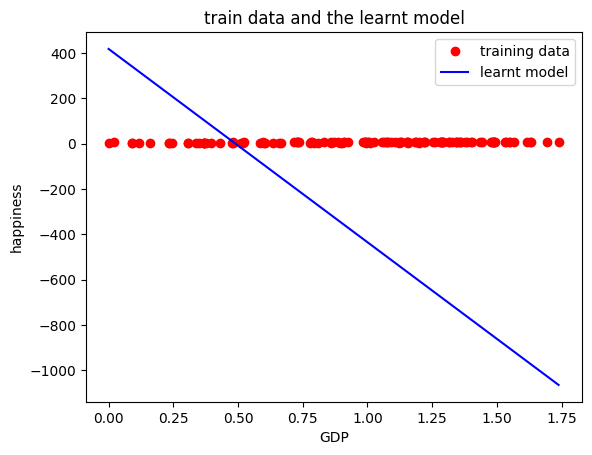

In [261]:
import matplotlib.pyplot as plt


w0, w1 = regresor.get_parameters()[0], regresor.get_parameters()[1]
noOfPoints = 1000
xref = []
val = min(training_input_set)
step = (max(training_input_set) - min(training_input_set)) / noOfPoints
for i in range(1, noOfPoints):
    xref.append(val)
    val += step
yref = [w0 + w1 * el for el in xref] 

fix,axes = plt.subplots()

axes.plot(training_input_set, training_output_set, 'ro', label = 'training data')  #train data are plotted by red and circle sign
axes.plot(xref, yref, 'b-', label = 'learnt model')                  #model is plotted by a blue line
axes.set_title('train data and the learnt model')
axes.set_xlabel('GDP')
axes.set_ylabel('happiness')
axes.legend()
plt.show()